# Multiple Linear Regression with Gapminder 

After completing supervised and unsupervised machine learning courses on DataCamp, as well as a machine learning DataCamp project (Reducing Traffic Mortality in the USA), I decided to complete two supervised machine learning projects on regression and classification seperately. 

I decided to show what I had learnt about regression using the Gapminder dataset from DataCamp. I predicted life expectancy, based on both categorical and numerical variables. 

In [84]:
#import necessary packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [85]:
#read in dataframe
df = pd.read_csv('gm_2008_region.csv')

In [86]:
#initial look at data 
df.head()

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality,Region
0,34811059,2.73,0.1,3.328945,24.59620,12314,29.9049,75.3,29.5,Middle East & North Africa
1,19842251,6.43,2.0,1.474353,22.25083,7103,30.1247,58.3,192.0,Sub-Saharan Africa
2,40381860,2.24,0.5,4.785170,27.50170,14646,18.8915,75.5,15.4,America
3,2975029,1.40,0.1,1.804106,25.35542,7383,32.8108,72.5,20.0,Europe & Central Asia
4,21370348,1.96,0.1,18.016313,27.56373,41312,17.3755,81.5,5.2,East Asia & Pacific


The Gapminder dataset takes examines countries (seperated into rows) in 2008. 

Gapminder explanation of variables : 

Fertility - the number of babies that would be born to each woman with prevailing age-specific fertility rates. 

HIV - percentage, age 15 to 49. 

CO2 - tonnes per person 

BMI - counted in kilogram per square meter. 

Life - the average number of years a newborn is expected to live if current mortality patterns stayed the same. 

Child mortality - 0 to 5 year olds dying per 1000 born. 

Before prediction begins, it's useful to do some Exploratory Data Analysis (EDA). 

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   population       139 non-null    int64  
 1   fertility        139 non-null    float64
 2   HIV              139 non-null    float64
 3   CO2              139 non-null    float64
 4   BMI_male         139 non-null    float64
 5   GDP              139 non-null    int64  
 6   BMI_female       139 non-null    float64
 7   life             139 non-null    float64
 8   child_mortality  139 non-null    float64
 9   Region           139 non-null    object 
dtypes: float64(7), int64(2), object(1)
memory usage: 11.0+ KB


In [88]:
print(df.isnull().sum())
#no missing values

population         0
fertility          0
HIV                0
CO2                0
BMI_male           0
GDP                0
BMI_female         0
life               0
child_mortality    0
Region             0
dtype: int64


In [89]:
df.describe()

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality
count,1.390000e+02,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,3.549977e+07,3.005108,1.915612,4.459874,24.623054,16638.784173,26.701914,69.602878,45.097122
std,1.095121e+08,1.615354,4.408974,6.268349,2.209368,19207.299083,4.471997,9.122189,45.724667
min,2.773150e+05,1.280000,0.060000,0.008618,20.397420,588.000000,17.375500,45.200000,2.700000
25%,3.752776e+06,1.810000,0.100000,0.496190,22.448135,2899.000000,23.232200,62.200000,8.100000
50%,9.705130e+06,2.410000,0.400000,2.223796,25.156990,9938.000000,26.519600,72.000000,24.000000
75%,2.791973e+07,4.095000,1.300000,6.589156,26.497575,23278.500000,30.275900,76.850000,74.200000
max,1.197070e+09,7.590000,25.900000,48.702062,28.456980,126076.000000,35.492000,82.600000,192.000000


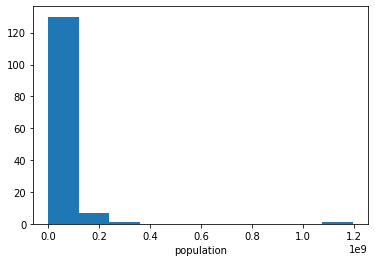

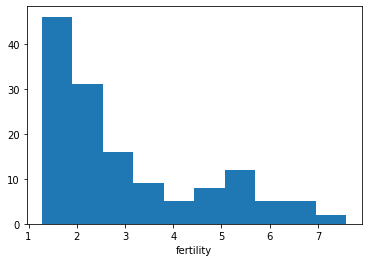

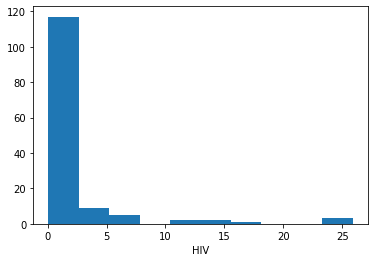

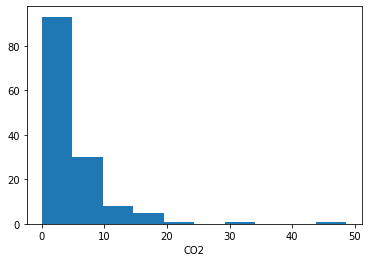

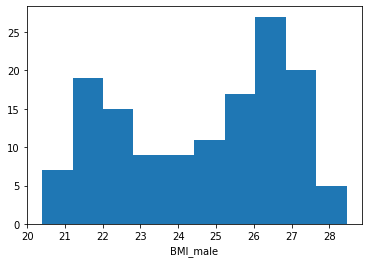

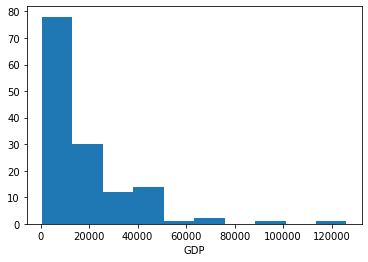

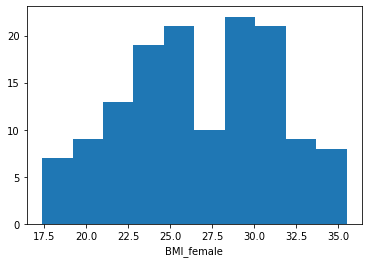

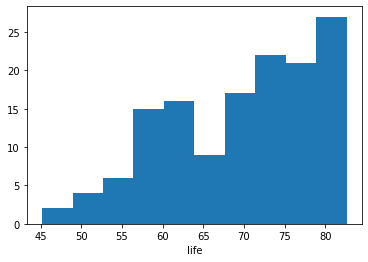

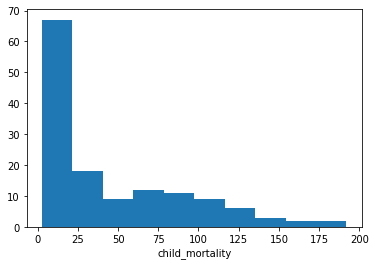

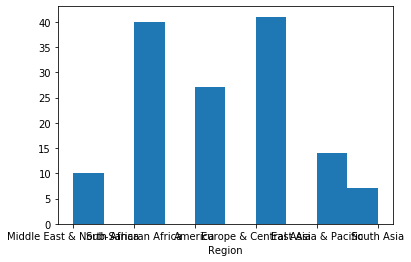

In [90]:
for column in df.columns : 
    plt.hist(df[column])
    plt.xlabel(column)
    plt.show()

Things to note from the histograms : 
Population : It looks as though there is one extreme outlier.

Fertility : most countries' fertility averages between 1 and 3 children. 

HIV: the majority of countries have a low percentage of HIV cases but there are a few countries with high amounts. 

CO2 : most countris lie between 0 and 10 tonnes per person. 

BMI_male/female : similarly distributed. 

GDP : most GDP lies between 0 and 50,000. 

Life expectancy : left skewed. 

Child mortality : right skewed 

A quick look at the only categorical variable: 

In [91]:
df['Region'].value_counts()

Europe & Central Asia         41
Sub-Saharan Africa            40
America                       27
East Asia & Pacific           14
Middle East & North Africa    10
South Asia                     7
Name: Region, dtype: int64

In [136]:
#examine numerical variables for correlation 
dfeda = df.drop('Region', axis = 1)

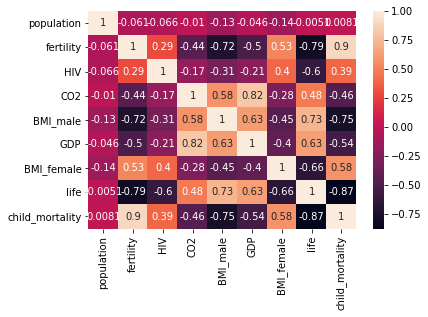

In [93]:
sns.heatmap(dfeda.corr(), annot = True)

The seaborn heatmap shows the correlation between features and with the target. 

Based on the heatmap, the population variable does not seem to correlate much with life expectancy. Dropping this should increase the score of our model, and based on testing on the training data, it does. 

In [94]:
df = df.drop('population',axis=1)

# Standardisation 

Since the data is measured in different ways e.g. population is in the billions whereas HIV is a percentage, standardisation might be useful before regression is performed. Standardising predictors makes the regression coefficients easier to interpret - the bigger the coefficient the bigger the impact of that predictor. This isn't true without standardisation because of multicollinearity (where some features are linearly related with others). 

Scaling is most useful when working with continuous features that are on different scales and are using a model that operates in a linear space, such as linear regression. This describes our data and model. Feature scaling transforms features so that they have a mean close to zero and a variance close to 1. 

In [95]:
#initial examination of variance
n = 0
for variance in df.var(): 
    print (df.columns[n], 'variance:',"{:.2f}".format(variance))
    n += 1

fertility variance: 2.61
HIV variance: 19.44
CO2 variance: 39.29
BMI_male variance: 4.88
GDP variance: 368920338.07
BMI_female variance: 20.00
life variance: 83.21
child_mortality variance: 2090.75


There is a lot of difference in variance between features.

In [96]:
#create a dataframe to be scaled
df_features = df.drop(['Region','life'], axis = 1)
#standard scaler transforms features 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns = df_features.columns)

In [97]:
#now recheck variance
df_scaled.var()

fertility          1.007246
HIV                1.007246
CO2                1.007246
BMI_male           1.007246
GDP                1.007246
BMI_female         1.007246
child_mortality    1.007246
dtype: float64

As seen above the features not only been reduced but the variance is both close to one and the same across all columns. 

The categorical variable, Region, in the features must be numerically encoded. This is done using pandas 'get_dummies', which creates new columns in the dataframe and assigns the feature a one if it exists in that column, a zero if not. Through testing, in this case scaling the encoded Region variable does not add to the accuracy of the model.

In [98]:
region_encoded = pd.get_dummies(df['Region'], drop_first = True)
#adding region to the scaled features 
features = pd.concat([df_scaled, region_encoded], axis = 1)

In [99]:
#life expectancy is the variable to be predicted
target = df['life'].values

Before regression can be performed, the data must be split into features and target variables (as done above), and then into training and test sets. The feature variables will be what we use to predict the target variable. 
Splitting into training and test sets allows us to see how well a model might generalise to new data.

In [110]:
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size = 0.3)

Multiple linear regression is a statistical technique that uses several independent variables to predict a dependent variable. The goal is to model a linear relationship between them. 

Linear regression is most easily understood when two variables, one feature and one target are considered. 
The regression line will take the form 

  $$y = ax + b$$

Where y is the target, x is the single feature and a and b are the parameters of the model that we want to learn. 

Intuitively, we want the line to be as close to the actual data as possible.

If we plot fertiliity against life expectancy, where fertililty is the feature and life expectancy is the target we would expect to see a negative correlation. What does this mean? It means that as fertility decreases, life expectancy increases. It is important to note that correlation does not imply causation.

y = -4.44x + 82.96


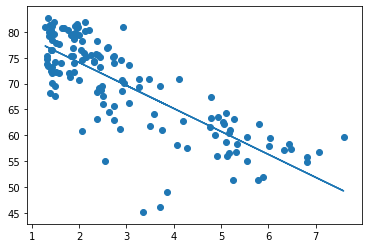

In [111]:
a, b = np.polyfit(df['fertility'],df['life'], 1)

plt.plot(df['fertility'], a*df['fertility'] + b)
plt.scatter(df['fertility'],df['life'])
print ('y = ', round(a,2),'x + ',round(b,2), sep = '')

The scikit learn linear regression model aims to minimise the distance (residuals) between the data points and the fit. To do this it performs OLS (Ordinary Least Squares) - minimising the squares of the residuals.

R-squared is a measure of how close the data is to the regression line. It is the percentage of the target variable's variation that is explained by our model. Thus, the higher this number the better. R-squared is the value returned when the linear regression model is scored. 

The first step to performing linear regression on the dataset is to create a linear regression regressor and to fit that to the training data. 

In [137]:
#create regressor and fit to training data 
linreg =LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

A good way of testing the accuracy of the linear regression model is using k-fold cross validation. Model performance is influenced by the way the data is split. The training set may have some odd information that means the model won't be able to generalise well.  

A solution to this is using cross validation. Here the data is split into five folds. With each iteration one of these folds is used as a test set and the others are used to train the model. This results in five values of R-squared. The average is then taken. 

In [127]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(linreg, X_train, y_train, cv =5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {:.4f}".format(np.mean(cv_scores)))


[0.75467568 0.79314229 0.82902654 0.8076659  0.8931816 ]
Average 5-Fold CV Score: 0.8155


Using cross-validation gives us a better idea of how the model will work on new data, and reduces the chances of overfitting. Overfitting is when the model learns the training data too well and so performs poorly on new data.  

## Lasso Regression

Performing lasso regression is a visual way to see which feature is most important in predicting the target. Lasso regression's loss function is the standard OLS function plus the absolute value of each coefficient multiplied by some constant alpha. Alpha = 0 is equivalent to the standard OLS. Lasso regression tends to reduce the coefficients of less important features to zero. 

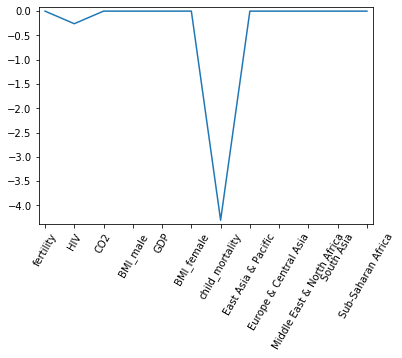

In [114]:
# create a lasso regressor
lasso = Lasso(alpha=0.3, normalize=True)

# Fit the regressor to the data
lasso.fit(features,target)
colnames = features.columns
#show on graph
plt.plot(range(len(colnames)), lasso.coef_)
plt.xticks(range(len(colnames)), colnames.values, rotation=60) 
plt.margins(0.02)
plt.show()

It's clear from the graph that the child mortality variable (the number of 0 to 5 year olds dying per 1000 born) is the greatest predictor of life expectancy. The percentage of people aged 15 to 49 with HIV is also an important predictor. 

# Principal Component Analysis 

PCA is a dimension reduction technique. PCA decorrelates the features. It rotates them so that they're in line with coordinate axes and shifts them so that they have mean 0. These features are now uncorrelated. This is how PCA learns the principal components of the data. These are the directions in which the samples vary the most. 

In [115]:
#create pca 
pca = PCA()
#fit transform features 
transformed_features = pca.fit_transform(features)
print(pca.explained_variance_ratio_)

[0.55915359 0.15108895 0.09958861 0.07782534 0.03845581 0.02612048
 0.01514066 0.01081058 0.00999042 0.00595923 0.00395227 0.00191406]


The explained variance ratio lists each PCA component from most to least variance. 

PCA without dimension reduction uses 12 components in its model. If we want our PCA model to capture 90% of the dataset's variance we can do so by counting the number of features whose proportions-of-variances-explained add up to 0.9.

In [116]:
feature_list = list()
ninety_var = 0
for var in pca.explained_variance_ratio_: 
    ninety_var += var 
    feature_list.append(var)
    if ninety_var >= 0.9: 
        break 
print (len(feature_list))
print (ninety_var)

5
0.9261122899265867


In [117]:
#pca with 5 components 
pca = PCA(n_components =5)
transformed_features = pca.fit_transform(features)

In [138]:
#transformed train test split
transformed_X_train, transformed_X_test, transformed_y_train, transformed_y_test = train_test_split(transformed_features,target, test_size = 0.3, random_state = 42)

In [119]:
pcalinreg =LinearRegression()
pcalinreg.fit(transformed_X_train, transformed_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [120]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(linreg, transformed_features, target, cv =5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {:.4f}".format(np.mean(cv_scores)))

[0.80055277 0.84672299 0.88456126 0.75356661 0.89677573]
Average 5-Fold CV Score: 0.8364


Using Principal Components Analysis to perform dimension reduction, and running the linear regression model on these reduced number of features, the R-squared value is 0.8364 with seven predictors as opposed to the original twelve. 

This doesn't hold a lot of weight here but when working with datasets with higher dimensions, reducing the number of predictors can increase computation time and removes redundant features. 

# Conclusion

Let's look at the regression coefficients that have standardised.

In [140]:
#create dataframe of coefficients corresponding to standardised features 
pd.DataFrame(linreg.coef_, features.columns, columns=['Coefficient'])[0:7]  

,Coefficient
fertility,-1.466555
HIV,-2.819757
CO2,-0.860576
BMI_male,-0.410836
GDP,3.088893
BMI_female,-1.469876
child_mortality,-4.729612


Since the features has been standardised, it can be seen at a glance which features are given the most weight in the linear regression model. 

Child mortality is the most important predictor (as seen in the Lasso regression. But here it can be seen that GDP and HIV are also important.  

On average, the better a country's health and wealth, the longer their average life expectancy is. This cannot be interpreted as causation though. There is no proof from this data that there is a direct causal link between, for example, child mortality and life expectancy, only that there is a correlation. 